In [61]:
import numpy as np
import pandas as pd
from pylab import plt, mpl

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
pd.set_option('display.precision', 4)
np.set_printoptions(suppress=True, precision=4)

url = 'https://hilpisch.com/aiif_eikon_eod_data.csv'
data = pd.read_csv(url, index_col=0, parse_dates=True).dropna()

<Axes: xlabel='Date'>

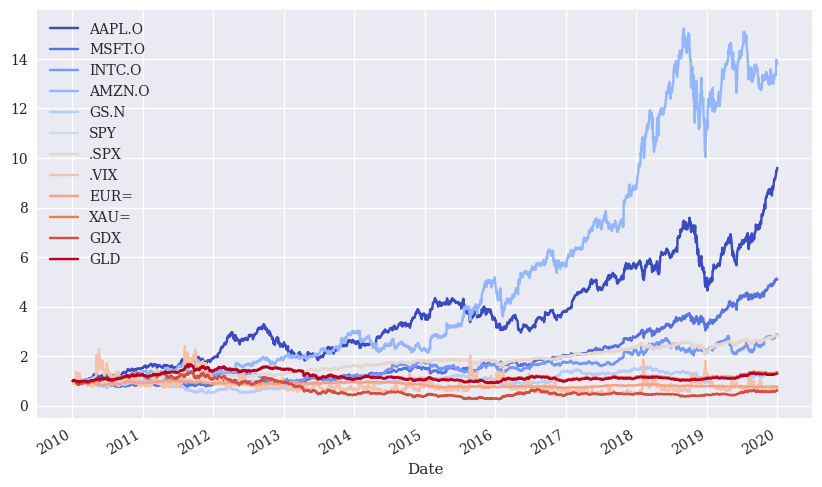

In [9]:
(data / data.iloc[0]).plot(figsize=(10,6), cmap= 'coolwarm')

In [11]:
lags = 7

def add_lags(data, ric, lags):
    cols = []
    df = pd.DataFrame(data[ric])

    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        df[col] = df[ric].shift(lag)
        cols.append(col)
    df.dropna(inplace=True)
    return df, cols

dfs = {}

for sym in data.columns:
    df, cols = add_lags(data, sym, lags)
    dfs[sym] = df

dfs[sym].head(7)

GLD   lag_1   lag_2   lag_3   lag_4   lag_5   lag_6   lag_7
Date                                                                      
2010-01-13  111.54  110.49  112.85  111.37  110.82  111.51  109.70  109.80
2010-01-14  112.03  111.54  110.49  112.85  111.37  110.82  111.51  109.70
2010-01-15  110.86  112.03  111.54  110.49  112.85  111.37  110.82  111.51
2010-01-19  111.52  110.86  112.03  111.54  110.49  112.85  111.37  110.82
2010-01-20  108.94  111.52  110.86  112.03  111.54  110.49  112.85  111.37
2010-01-21  107.37  108.94  111.52  110.86  112.03  111.54  110.49  112.85
2010-01-22  107.17  107.37  108.94  111.52  110.86  112.03  111.54  110.49

In [13]:
regs = {}
for sym in data.columns:
    df = dfs[sym]
    reg = np.linalg.lstsq(df[cols], df[sym], rcond=-1)[0]
    regs[sym] = reg

rega = np.stack(tuple(regs.values()))
regd  = pd.DataFrame(rega, columns=cols, index=data.columns)

regd

lag_1   lag_2   lag_3   lag_4   lag_5   lag_6   lag_7
AAPL.O  1.0106 -0.0592  0.0258  0.0535 -0.0172  0.0060 -0.0184
MSFT.O  0.8928  0.0112  0.1175 -0.0832 -0.0258  0.0567  0.0323
INTC.O  0.9519  0.0579  0.0490 -0.0772 -0.0373  0.0449  0.0112
AMZN.O  0.9799 -0.0134  0.0206  0.0007  0.0525 -0.0452  0.0056
GS.N    0.9806  0.0342 -0.0172  0.0042 -0.0387  0.0585 -0.0215
SPY     0.9692  0.0067  0.0228 -0.0244 -0.0237  0.0379  0.0121
.SPX    0.9672  0.0106  0.0219 -0.0252 -0.0318  0.0515  0.0063
.VIX    0.8823  0.0591 -0.0289  0.0284 -0.0256  0.0511  0.0306
EUR=    0.9859  0.0239 -0.0484  0.0508 -0.0217  0.0149 -0.0055
XAU=    0.9864  0.0069  0.0166 -0.0215  0.0044  0.0198 -0.0125
GDX     0.9765  0.0096 -0.0039  0.0223 -0.0364  0.0379 -0.0065
GLD     0.9766  0.0246  0.0060 -0.0142 -0.0047  0.0223 -0.0106

<Axes: >

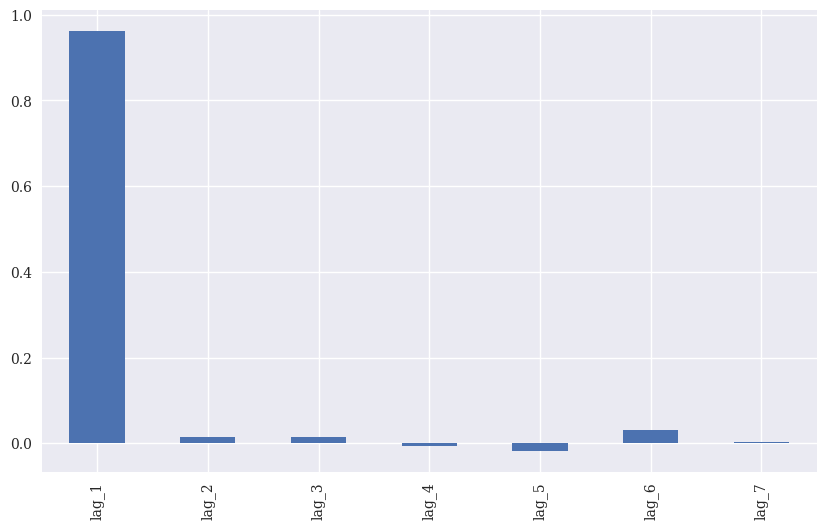

In [14]:
regd.mean().plot(kind='bar', figsize=(10,6))

In [15]:
dfs[sym].corr()

GLD   lag_1   lag_2   lag_3   lag_4   lag_5   lag_6   lag_7
GLD    1.0000  0.9972  0.9946  0.9920  0.9893  0.9867  0.9841  0.9815
lag_1  0.9972  1.0000  0.9972  0.9946  0.9920  0.9893  0.9867  0.9842
lag_2  0.9946  0.9972  1.0000  0.9972  0.9946  0.9920  0.9893  0.9867
lag_3  0.9920  0.9946  0.9972  1.0000  0.9972  0.9946  0.9920  0.9893
lag_4  0.9893  0.9920  0.9946  0.9972  1.0000  0.9972  0.9946  0.9920
lag_5  0.9867  0.9893  0.9920  0.9946  0.9972  1.0000  0.9972  0.9946
lag_6  0.9841  0.9867  0.9893  0.9920  0.9946  0.9972  1.0000  0.9972
lag_7  0.9815  0.9842  0.9867  0.9893  0.9920  0.9946  0.9972  1.0000

In [18]:
from statsmodels.tsa.stattools import adfuller

In [19]:
adfuller(data[sym].dropna())

(-1.9488969577009956,
 0.3094193074034716,
 0,
 2515,
 {'1%': -3.4329527780962255,
  '5%': -2.8626898965523724,
  '10%': -2.567382133955709},
 8446.683102944744)

In [45]:
rets = np.log(data / data.shift(1))
rets.dropna(inplace=True)

dfs = {}

for sym in data:
    df, cols = add_lags(rets, sym, lags)    
    mu, std = df[cols].mean(), df[cols].std()
    df[cols] = (df[cols] - mu) / std    
    dfs[sym] = df

adfuller(dfs[sym]['lag_1'])
dfs[sym].corr()

GLD   lag_1   lag_2       lag_3   lag_4       lag_5   lag_6   lag_7
GLD    1.0000 -0.0297  0.0003  1.2635e-02 -0.0026 -5.9392e-03  0.0099 -0.0013
lag_1 -0.0297  1.0000 -0.0305  8.1418e-04  0.0128 -2.8765e-03 -0.0053  0.0098
lag_2  0.0003 -0.0305  1.0000 -3.1617e-02  0.0003  1.3234e-02 -0.0043 -0.0052
lag_3  0.0126  0.0008 -0.0316  1.0000e+00 -0.0313 -6.8542e-06  0.0141 -0.0044
lag_4 -0.0026  0.0128  0.0003 -3.1329e-02  1.0000 -3.1761e-02  0.0002  0.0141
lag_5 -0.0059 -0.0029  0.0132 -6.8542e-06 -0.0318  1.0000e+00 -0.0323  0.0002
lag_6  0.0099 -0.0053 -0.0043  1.4115e-02  0.0002 -3.2289e-02  1.0000 -0.0324
lag_7 -0.0013  0.0098 -0.0052 -4.3869e-03  0.0141  2.1707e-04 -0.0324  1.0000

In [52]:
from sklearn.metrics import accuracy_score

%time
for sym in data:
    df = dfs[sym]
    reg = np.linalg.lstsq(df[cols], df[sym], rcond=-1)[0]
    pred = np.dot(df[cols], reg)
    acc = accuracy_score(np.sign(df[sym]), np.sign(pred))
    print(f'OLS | {sym:10s} | acc= {acc:.4f}')

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.87 µs
OLS | AAPL.O     | acc= 0.5056
OLS | MSFT.O     | acc= 0.5088
OLS | INTC.O     | acc= 0.5040
OLS | AMZN.O     | acc= 0.5048
OLS | GS.N       | acc= 0.5080
OLS | SPY        | acc= 0.5080
OLS | .SPX       | acc= 0.5167
OLS | .VIX       | acc= 0.5291
OLS | EUR=       | acc= 0.4984
OLS | XAU=       | acc= 0.5207
OLS | GDX        | acc= 0.5307
OLS | GLD        | acc= 0.5072


In [53]:
from sklearn.neural_network import MLPRegressor

%time
for sym in data.columns:
    df = dfs[sym]
    model = MLPRegressor(
        hidden_layer_sizes=[512],
        random_state=100,
        max_iter=1000,
        early_stopping=True,
        validation_fraction=0.15,
        shuffle=False)
    model.fit(df[cols], df[sym])
    pred = model.predict(df[cols])
    acc = accuracy_score(np.sign(df[sym]), np.sign(pred))
    print(f'MLP | {sym:10s} | acc= {acc:.4f}') 

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 10.7 µs
MLP | AAPL.O     | acc= 0.6005
MLP | MSFT.O     | acc= 0.5853
MLP | INTC.O     | acc= 0.5766
MLP | AMZN.O     | acc= 0.5510
MLP | GS.N       | acc= 0.6527
MLP | SPY        | acc= 0.5419
MLP | .SPX       | acc= 0.5399
MLP | .VIX       | acc= 0.6579
MLP | EUR=       | acc= 0.5642
MLP | XAU=       | acc= 0.5522
MLP | GDX        | acc= 0.6029
MLP | GLD        | acc= 0.5259


In [64]:
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential


np.random.seed(100)
tf.random.set_seed(100)

def create_model(problem='regression'):
    model = Sequential()
    model.add(Dense(512, input_dim=len(cols), activation='relu'))
    if problem == 'regression':
        model.add(Dense(1, activation='linear'))
        model.compile(loss='mse', optimizer='adam')
    else:
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam')
    return model 

%time
for sym in data.columns[:]:
    df = dfs[sym]
    model = create_model()
    model.fit(df[cols], df[sym], epochs=25, verbose=False)
    pred = model.predict(df[cols])
    acc = accuracy_score(np.sign(df[sym]), np.sign(pred))
    print(f'DNN | {sym:10s} | acc= {acc:.4f}')

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 5.72 µs
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step
DNN | AAPL.O     | acc= 0.5128
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step
DNN | MSFT.O     | acc= 0.6328
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step
DNN | INTC.O     | acc= 0.5251
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step
DNN | AMZN.O     | acc= 0.4912
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step
DNN | GS.N       | acc= 0.5905
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step
DNN | SPY        | acc= 0.5933
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step
DNN | .SPX       | acc= 0.5670
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step
DNN | .VIX       | acc= 0.6192
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step
DNN | EUR=       | acc= 0.5375
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
DNN | XAU=       | acc= 0.5610
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step
DNN | GDX        | acc= 0.5965
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step
DNN | GLD        | acc= 0.6124


In [76]:
split = int(len(dfs[sym]) * 0.8)

%time
for sym in data.columns:
    df = dfs[sym]
    train  = df.iloc[:split]
    reg = np.linalg.lstsq(train[cols], train[sym], rcond=-1)[0]
    test  = df.iloc[split:]
    pred = np.dot(test[cols], reg)    
    acc = accuracy_score(np.sign(test[sym]), np.sign(pred))
    print(f'OLS | {sym:10s} | acc= {acc:.4f}')

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 7.87 µs
OLS | AAPL.O     | acc= 0.5219
OLS | MSFT.O     | acc= 0.4960
OLS | INTC.O     | acc= 0.5418
OLS | AMZN.O     | acc= 0.4841
OLS | GS.N       | acc= 0.4980
OLS | SPY        | acc= 0.5020
OLS | .SPX       | acc= 0.5120
OLS | .VIX       | acc= 0.5458
OLS | EUR=       | acc= 0.4482
OLS | XAU=       | acc= 0.5299
OLS | GDX        | acc= 0.5159
OLS | GLD        | acc= 0.5100


Num GPUs Available:  0
